In [31]:
%pip install opencv-python matplotlib numpy pandas scikit-learn scikit-image scipy seaborn --quiet
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\ArilAprilio\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Bagian kode ini melakukan proses import library yang akan digunakan untuk seluruh proses ekstraksi fitur, klasifikasi, dan evaluasi pengolahan citra. Library `os` digunakan untuk membaca file dataset, `cv2` digunakan untuk membaca dan memproses gambar, `matplotlib.pyplot` serta `seaborn` dipakai untuk visualisasi data, sedangkan `numpy` dan `pandas` digunakan untuk pengolahan array dan manajemen data. Fungsi pembagian dataset dilakukan dengan `train_test_split` dari `sklearn.model_selection`, serta evaluasi model menggunakan beberapa metrik seperti `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `confusion_matrix`, dan `classification_report` dari `sklearn.metrics`. Untuk proses ekstraksi fitur tekstur gambar, digunakan `graycomatrix` dan `graycoprops` dari `skimage.feature`, serta `entropy` dari `scipy.stats` sebagai tambahan fitur statistik. Tiga algoritma klasifikasi utama yang diimpor adalah `RandomForestClassifier`, `SVC` (Support Vector Classifier), dan `KNeighborsClassifier` dari `sklearn`, yang akan digunakan pada tahap klasifikasi citra nantinya.

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

### Preprocessing Dataset Daun untuk Klasifikasi

Pada bagian ini dilakukan proses pembacaan dataset citra daun yang tersimpan dalam folder, dilanjutkan dengan resizing gambar agar seragam ukurannya, serta pemberian label otomatis berdasarkan nama folder. Proses ini penting untuk mempersiapkan data yang akan dipakai dalam training model klasifikasi citra.

Fungsi `resize_citra`

Fungsi ini digunakan untuk mengubah ukuran gambar menjadi ukuran persegi tertentu. Fungsi memeriksa apakah gambar memiliki 3 channel warna (RGB) atau 1 channel (grayscale), lalu membuat array kosong pada variabel `keluaran` sesuai jumlah channel. Proses resizing dilakukan dengan cara nearest neighbor interpolation, di mana koordinat sumber diambil dengan rumus `src_i = int(i * h / ukuran)` dan `src_j = int(j * w / ukuran)`. Gambar hasil resize dikembalikan dalam tipe data yang sama dengan gambar aslinya.

Fungsi `ubah_ke_gray`

Fungsi ini digunakan untuk mengonversi gambar RGB menjadi grayscale dengan perhitungan luminansi standar: `0.2989 * R + 0.5870 * G + 0.1140 * B`. Jika gambar sudah berupa grayscale (satu channel), maka dikembalikan langsung.

Proses utama membaca dataset dilakukan dengan membaca seluruh sub-folder yang ada di dalam folder `dataset/`. Setiap sub-folder mewakili satu kelas label (misalnya `healthy`, `leafblast`, dsb). Loop `for sub_folder in os.listdir("dataset/"):` digunakan untuk mengiterasi semua folder, diabaikan jika folder diawali dengan titik.

Setiap gambar dalam sub-folder dibaca menggunakan `plt.imread`, lalu di-resize ke ukuran 512x512 pixel menggunakan fungsi `resize_citra`. Gambar hasil resize dimasukkan ke dalam list `data`, sedangkan nama folder yang merupakan label kelas dimasukkan ke list `labels`.

Setelah semua gambar dibaca, list `data` dan `labels` dikonversi menjadi array. Label berupa nama kelas dikonversi menjadi index numerik dengan mapping dictionary `label_to_index`. Ini memudahkan saat model machine learning digunakan, karena model biasanya bekerja dengan label numerik.

Sebagai visualisasi contoh data, gambar dari dua kelas diambil secara manual: `healthy` dan `leafblast`. Keduanya ditampilkan dalam figure Matplotlib menggunakan subplot 1x2, masing-masing diberi label judul sesuai nama kelasnya.

Jumlah data: 200
Jumlah kelas: 2


Text(0.5, 1.0, 'Leaf Blast')

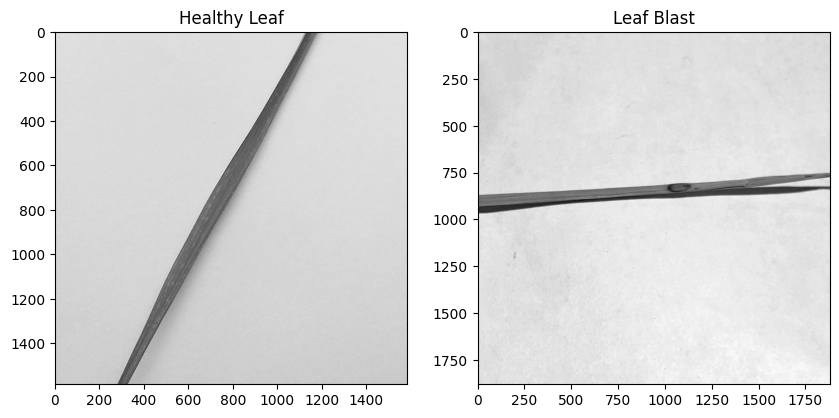

In [32]:
def resize_citra(gambar, ukuran):
    h, w = gambar.shape[:2]
    if gambar.ndim == 3:
        c = gambar.shape[2]
        keluaran = np.zeros((ukuran, ukuran, c), dtype=gambar.dtype)
    else:
        keluaran = np.zeros((ukuran, ukuran), dtype=gambar.dtype)
    for i in range(ukuran):
        for j in range(ukuran):
            src_i = int(i * h / ukuran)
            src_j = int(j * w / ukuran)
            keluaran[i, j] = gambar[src_i, src_j]
    return keluaran

def ubah_ke_gray(gambar):
    if gambar.ndim == 3:
        return np.dot(gambar[..., :3], [0.2989, 0.5870, 0.1140])
    return gambar

data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    if sub_folder.startswith("."):
        continue

    sub_folder_path = os.path.join("dataset/", sub_folder)
    if os.path.isdir(sub_folder_path):
        sub_folder_files = os.listdir(sub_folder_path)
        for filename in sub_folder_files:
            img_path = os.path.join(sub_folder_path, filename)

            img = plt.imread(img_path)
            resize_img = resize_citra(img, 512)
            resize_img = ubah_ke_gray(resize_img)
            resize_img = resize_img.astype(np.uint8)

            data.append(resize_img)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)
print("Jumlah data:", len(data))
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])
print("Jumlah kelas:", len(unique_labels))

healthy = plt.imread("dataset/healthy/image1.jpg")
leafblast = plt.imread("dataset/leafblast/image1.jpg")

healthy = ubah_ke_gray(healthy)
leafblast = ubah_ke_gray(leafblast)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(healthy, cmap='gray')
plt.title("Healthy Leaf")

plt.subplot(1, 2, 2)
plt.imshow(leafblast, cmap='gray')
plt.title("Leaf Blast")

## Data Augmentation

### Define Augmentation Function


In [33]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [34]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  0


## Data Preparation

Tanpa preprocessing

In [35]:
dataPreprocessed = data

### Feature Extraction

Fungsi `glcm()`

Digunakan untuk menghitung Gray Level Co-occurrence Matrix (GLCM) dari sebuah gambar grayscale pada sudut tertentu, yang nantinya akan dipakai untuk ekstraksi fitur tekstur. Fungsi menerima parameter `image` dan `derajat`. Sudut input dalam derajat akan dikonversikan ke radian, misalnya `0` derajat ke `0`, `45` derajat ke `π/4`, `90` derajat ke `π/2`, dan `135` derajat ke `3π/4`. Jika derajat yang dimasukkan tidak termasuk 0, 45, 90, atau 135, maka fungsi akan menampilkan error. Setelah sudut ditentukan, fungsi memanggil `graycomatrix` dengan jarak offset 1 pixel, menghasilkan matriks GLCM berukuran 256 level gray, menggunakan opsi `symmetric=True` dan `normed=True` agar hasil matriks bersifat simetris dan ternormalisasi.


In [36]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [37]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi `correlation()`

Digunakan untuk menghitung nilai correlation dari matriks GLCM yang sudah dihitung sebelumnya. Correlation menunjukkan hubungan linear antar pixel dalam citra, dihitung dengan memanggil `graycoprops(matriks, 'correlation')` dan mengambil hasil dari indeks `[0, 0]` karena output `graycoprops` berupa matriks.

In [38]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi `dissimilarity()`

Digunakan untuk menghitung nilai **dissimilarity** dari GLCM yang mengukur seberapa besar perbedaan antar level gray pada pixel yang bersebelahan. Semakin tinggi nilainya, semakin besar variasi antara pixel. Nilai dihitung dengan `graycoprops(matriks, 'dissimilarity')[0, 0]`.

In [39]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi `homogenity()`

Digunakan untuk menghitung nilai **homogeneity** dari GLCM yang mengukur seberapa homogen atau meratanya distribusi level gray pada citra. Semakin tinggi nilai homogeneity, berarti perbedaan intensitas antar pixel kecil. Nilai diperoleh dari `graycoprops(matriks, 'homogeneity')[0, 0]`.

In [40]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi `contrast()`

Digunakan untuk menghitung nilai kontras dari GLCM yang menunjukkan perbedaan kontras atau ketajaman perbedaan intensitas antar pixel tetangga. Nilai contrast dihitung dengan `graycoprops(matriks, 'contrast')[0, 0]`.

In [41]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi `ASM()`

Digunakan untuk menghitung nilai Angular Second Moment (ASM) dari GLCM, yang juga dikenal sebagai uniformity atau energy squared. ASM mengukur kekonsistenan tekstur citra, dihitung menggunakan `graycoprops(matriks, 'ASM')[0, 0]`.

In [42]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi `energy()`

Digunakan untuk menghitung nilai energy dari GLCM, yang merupakan akar kuadrat dari ASM, sehingga menunjukkan keseragaman energi tekstur citra. Dihitung menggunakan `graycoprops(matriks, 'energy')[0, 0]`.

In [43]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi `entropyGlcm()`

Digunakan untuk menghitung nilai entropy dari GLCM yang mengukur tingkat ketidakteraturan atau kompleksitas tekstur. Perhitungannya menggunakan `entropy(matriks.ravel())` dari `scipy.stats` yang menghitung entropi dari vektor datar (flattened) GLCM.

In [44]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Pada bagian ini dilakukan proses ekstraksi matriks GLCM dari setiap gambar hasil preprocessing `dataPreprocessed` menggunakan beberapa sudut berbeda yaitu 0°, 45°, 90°, dan 135°. Tujuannya agar fitur tekstur yang dihasilkan lebih representatif, karena pola tekstur citra bisa muncul pada berbagai orientasi. Looping dilakukan sepanjang jumlah data dengan `for i in range(len(dataPreprocessed))`. Pada setiap iterasi, satu gambar diproses menggunakan fungsi `glcm()` sebanyak empat kali, masing-masing dengan parameter sudut `0`, `45`, `90`, dan `135`. Hasil dari masing-masing GLCM yang dihasilkan dari tiap sudut disimpan ke dalam empat list berbeda, yaitu `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Dengan cara ini, setiap gambar pada dataset akan memiliki 4 buah GLCM yang nantinya akan dipakai untuk menghitung fitur-fitur statistik teksturnya.


In [45]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Pada bagian ini dilakukan proses pendefinisian list kosong yang akan digunakan untuk menyimpan hasil perhitungan fitur-fitur tekstur dari GLCM. Setiap fitur akan memiliki empat list, sesuai dengan jumlah sudut GLCM yang digunakan yaitu `0°`, `45°`, `90°`, dan `135°`. List yang diinisialisasi meliputi: `Kontras`, `dissimilarity`, `homogenity`, `entropy`, `ASM`, `energy`, dan `correlation`. Masing-masing dari fitur tersebut akan menyimpan hasil ekstraksi statistik dari fungsi-fungsi yang sebelumnya sudah dibuat. Dengan membuat list kosong ini di awal, maka hasil penghitungan dari setiap gambar bisa langsung ditambahkan ke list yang sesuai berdasarkan sudutnya.


In [46]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Pada bagian ini dilakukan proses perhitungan fitur `correlation` dari matriks GLCM yang sebelumnya sudah dihitung untuk setiap gambar di dataset pada masing-masing sudut orientasi. Proses dilakukan dengan cara looping sebanyak jumlah data menggunakan `for i in range(len(dataPreprocessed))`. Setiap iterasi akan memproses 4 buah GLCM (satu sudut per GLCM) yang tersimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Untuk masing-masing GLCM, nilai correlation dihitung menggunakan fungsi `correlation()` yang sebelumnya telah didefinisikan. Hasil correlation pada masing-masing sudut kemudian langsung disimpan ke dalam list `correlation0`, `correlation45`, `correlation90`, dan `correlation135` sesuai sudutnya.


In [47]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Pada bagian ini dilakukan proses perhitungan fitur `contrast` dari GLCM hasil ekstraksi sebelumnya pada masing-masing sudut (0°, 45°, 90°, dan 135°). Sama seperti proses sebelumnya, looping dilakukan sebanyak jumlah data dengan `for i in range(len(data))`, lalu pada setiap iterasi akan menghitung nilai `contrast` dari masing-masing GLCM sudut menggunakan fungsi `contrast()` yang sudah didefinisikan sebelumnya. Setelah dihitung, nilai `contrast` untuk tiap sudut langsung disimpan ke list yang sesuai, yaitu `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`.


In [48]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Pada bagian ini dilakukan proses perhitungan fitur `dissimilarity` dari matriks GLCM pada masing-masing sudut orientasi (0°, 45°, 90°, dan 135°). Proses looping tetap menggunakan `for i in range(len(data))` untuk mengiterasi seluruh gambar yang ada di dataset. Setiap GLCM pada sudut tertentu diproses menggunakan fungsi `dissimilarity()` yang sebelumnya telah dibuat, dan hasil dari masing-masing sudut langsung disimpan ke dalam list `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`. Fitur dissimilarity ini akan menggambarkan seberapa besar ketidaksamaan nilai intensitas antar pixel yang bersebelahan, di mana semakin besar nilainya maka tekstur cenderung semakin variatif.

In [49]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Pada bagian ini dilakukan proses perhitungan fitur `homogeneity` dari masing-masing GLCM yang sudah dihitung sebelumnya pada sudut 0°, 45°, 90°, dan 135°. Sama seperti proses fitur sebelumnya, dilakukan looping untuk seluruh data menggunakan `for i in range(len(data))`, kemudian masing-masing GLCM diproses menggunakan fungsi `homogenity()`. Hasil dari perhitungan homogeneity untuk tiap sudut langsung disimpan ke dalam list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Nilai homogeneity ini menunjukkan seberapa besar keseragaman tekstur, di mana nilai yang lebih tinggi menunjukkan bahwa nilai intensitas antar piksel relatif seragam atau mirip.

In [50]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Pada bagian ini dilakukan proses perhitungan fitur `entropy` dari masing-masing matriks GLCM pada sudut 0°, 45°, 90°, dan 135°. Looping dilakukan ke seluruh data dengan `for i in range(len(data))`, lalu tiap GLCM diproses menggunakan fungsi `entropyGlcm()`. Hasil perhitungan entropy dari masing-masing sudut kemudian disimpan ke dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135`. Nilai entropy ini menggambarkan tingkat ketidakteraturan atau kompleksitas tekstur gambar — semakin tinggi entropy, maka tekstur gambar semakin kompleks atau acak.

In [51]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Pada bagian ini dilakukan proses perhitungan fitur `ASM (Angular Second Moment)` dari masing-masing GLCM pada keempat sudut (0°, 45°, 90°, dan 135°). Proses looping dilakukan dengan `for i in range(len(data))`, kemudian setiap GLCM diproses menggunakan fungsi `ASM()`. Hasil nilai ASM dari masing-masing sudut kemudian disimpan ke dalam list `ASM0`, `ASM45`, `ASM90`, dan `ASM135`. Nilai ASM ini mencerminkan tingkat keseragaman atau kekonsistenan tekstur citra — semakin besar nilai ASM, berarti tekstur semakin seragam antara flat atau smooth.


In [52]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Pada bagian ini dilakukan proses perhitungan fitur `energy` dari masing-masing matriks GLCM pada sudut 0°, 45°, 90°, dan 135°. Proses looping dilakukan pada seluruh data dengan `for i in range(len(data))`, lalu setiap GLCM dihitung menggunakan fungsi `energy()`. Hasil perhitungan dari masing-masing sudut langsung disimpan ke dalam list `energy0`, `energy45`, `energy90`, dan `energy135`. Nilai `energy` ini sendiri merepresentasikan akar kuadrat dari ASM, yang menunjukkan tingkat keseragaman energi dalam tekstur citra. Semakin tinggi nilainya, semakin stabil dan halus teksturnya.

### Write the extraction's results to CSV

Pada bagian ini dilakukan proses penggabungan semua fitur hasil ekstraksi ke dalam satu tabel dataframe. Dictionary `dataTable` dibuat berisi semua data, dimulai dari `Filename`, `Label`, serta seluruh fitur GLCM `Contrast`, `Homogeneity`, `Dissimilarity`, `Entropy`, `ASM`, `Energy`, dan `Correlation` dari keempat sudut pengambilan. Setelah dictionary lengkap, dibuat dataframe menggunakan `pd.DataFrame(dataTable)` dari library pandas. Dataframe ini kemudian langsung disimpan ke file CSV dengan nama `hasil_ekstraksi_1.csv` menggunakan `to_csv()`, agar hasilnya bisa diakses, dianalisis, atau digunakan kembali tanpa harus melakukan ekstraksi ulang. Untuk memastikan file tersimpan dengan benar, file CSV hasil ekstraksi kembali dibaca menggunakan `pd.read_csv()` ke dalam variabel `hasilEkstrak` lalu ditampilkan.


In [53]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,image1.jpg,0,43.248853,58.615569,26.242195,22.469522,0.366037,0.354859,0.362190,0.360826,...,0.006450,0.006477,0.081214,0.080204,0.080309,0.080479,0.951741,0.934618,0.970679,0.974936
1,image10.jpg,0,37.911127,31.935693,56.965948,76.522110,0.322883,0.306098,0.323012,0.300588,...,0.007674,0.007221,0.087169,0.085332,0.087599,0.084978,0.976329,0.980094,0.964492,0.952303
2,image100.jpg,0,45.729379,68.063331,77.243422,87.760670,0.260092,0.232316,0.249398,0.229945,...,0.002145,0.002012,0.046892,0.045079,0.046313,0.044857,0.974302,0.961806,0.956668,0.950753
3,image11.jpg,0,42.476975,104.468266,91.201095,70.328036,0.281453,0.260655,0.280711,0.263073,...,0.004974,0.004730,0.070045,0.068654,0.070529,0.068778,0.982983,0.958216,0.963520,0.971871
4,image12.jpg,0,23.439526,18.550193,28.778364,49.113445,0.392731,0.365334,0.383437,0.361380,...,0.011033,0.010395,0.106376,0.102234,0.105038,0.101957,0.980155,0.984323,0.975682,0.958493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,image95.jpg,1,9.919822,8.000234,6.208568,16.072403,0.552667,0.454895,0.537525,0.457948,...,0.008990,0.006586,0.097851,0.080303,0.094814,0.081154,0.987084,0.989579,0.991905,0.979063
196,image96.jpg,1,21.762839,11.684219,10.328737,39.569793,0.493458,0.411072,0.490398,0.414044,...,0.007862,0.005900,0.089472,0.076396,0.088669,0.076814,0.950718,0.973526,0.976582,0.910342
197,image97.jpg,1,11.837313,8.040908,6.663470,21.166704,0.508422,0.425651,0.497202,0.430819,...,0.008032,0.006090,0.090670,0.077455,0.089621,0.078040,0.969400,0.979201,0.982755,0.945247
198,image98.jpg,1,17.633665,10.074046,7.007855,32.217416,0.597600,0.487049,0.589476,0.492780,...,0.012885,0.009389,0.115274,0.095630,0.113511,0.096897,0.972426,0.984243,0.989019,0.949609


### Features Selection

Pada bagian ini dilakukan proses pemilihan fitur yang saling tidak terlalu berkorelasi untuk mengurangi kemungkinan terjadinya multikolinearitas antar fitur pada saat training model. Pertama, dihitung matriks korelasi antar fitur menggunakan `hasilEkstrak.drop(columns=['Label','Filename']).corr()` untuk menghilangkan kolom non-fitur (label & filename), sehingga hanya fitur numerik yang tersisa.

Selanjutnya dilakukan penyaringan fitur dengan logika: jika ada dua fitur yang memiliki korelasi sangat tinggi atau lebih besar dari threshold 0.95, maka salah satu dari keduanya akan dibuang. Hal ini dilakukan dengan nested loop `for i in range(correlation.shape[0]):` dan `for j in range(i+1, correlation.shape[0]):`, di mana fitur kedua `j` dihapus jika korelasinya melebihi threshold dan `columns[j]` diatur menjadi `False`.

Setelah seleksi fitur selesai, fitur yang lolos disimpan ke dalam variabel `x_new` menggunakan `hasilEkstrak[select]`, sedangkan label target disimpan di variabel `y`. Akhirnya, dilakukan visualisasi ulang korelasi antar fitur hasil seleksi menggunakan heatmap `sns.heatmap()` untuk memastikan bahwa fitur yang tersisa memang sudah minim korelasi tinggi, dengan tampilan anotasi nilai korelasi agar mudah dibaca.


pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

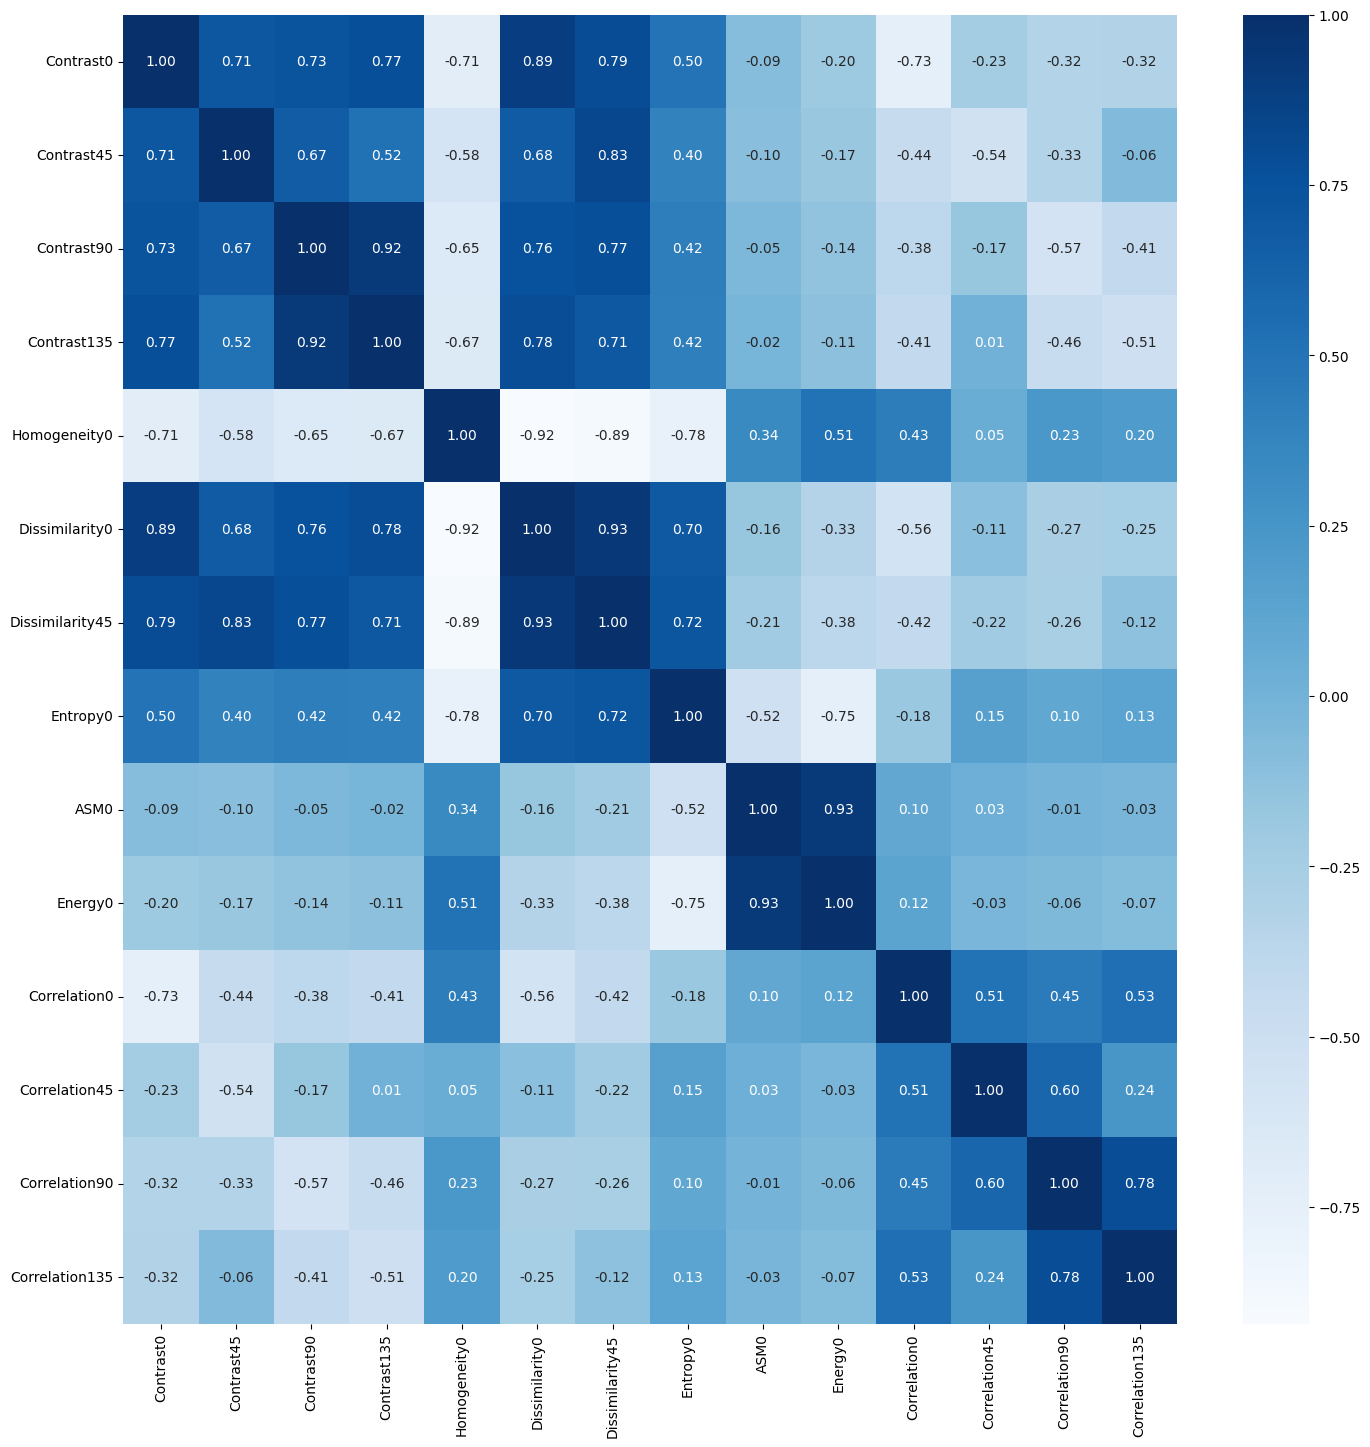

In [54]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### Splitting Data

Pada bagian ini dilakukan proses pembagian dataset menjadi data training dan data testing menggunakan fungsi `train_test_split` dari library `sklearn.model_selection`. Dataset fitur yang sudah diseleksi `x_new` dipasangkan dengan label target `y` untuk dipisah menjadi dua bagian: `X_train` dan `X_test` untuk data fitur, serta `y_train` dan `y_test` untuk label masing-masing.

Parameter `test_size=0.2` berarti 20% data digunakan untuk pengujian, sementara 80% sisanya digunakan untuk pelatihan. Pemisahan dilakukan secara acak tetapi tetap konsisten dengan seed acak `random_state=42`, sehingga hasil split selalu sama jika kode dijalankan ulang.

In [55]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 14)
(40, 14)


## Feature Normalization

Pada bagian ini dilakukan proses normalisasi data menggunakan metode standar skor z-score, yaitu dengan mengurangi nilai rata-rata dan membaginya dengan standar deviasi pada masing-masing fitur. Normalisasi ini penting dilakukan karena sebagian besar algoritma machine learning sensitif terhadap skala data.

Proses normalisasi dilakukan dengan rumus `X_new = (X - mean) / std`, dimana `mean` dan `std` diambil dari data training `X_train.mean()` dan `X_train.std()` agar informasi distribusi tetap berasal dari data latih saja, dan diterapkan ke data training maupun data testing.

Dengan demikian, baik `X_train` maupun `X_test` memiliki skala data yang seragam sehingga mempercepat proses konvergensi training model dan meningkatkan performa akurasi. Selain itu, hal ini juga mencegah dominasi fitur yang memiliki rentang nilai lebih besar dibanding fitur lainnya.

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [56]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

Fungsi `generateClassificationReport()`

Fungsi ini digunakan untuk menampilkan hasil evaluasi performa model klasifikasi secara lengkap. Fungsi menerima dua parameter yaitu `y_true` atau label sebenarnya, dan `y_pred` atau label prediksi hasil model. Di dalamnya dipanggil fungsi `classification_report()` dari `sklearn.metrics` untuk menampilkan metrik precision, recall, f1-score, dan support untuk tiap kelas. Selain itu, juga ditampilkan confusion matrix menggunakan `confusion_matrix()` dan skor akurasi total menggunakan `accuracy_score()`.

Kemudian didefinisikan tiga model klasifikasi yang akan digunakan, yaitu `RandomForestClassifier` dengan 5 pohon `n_estimators=5` dan random state 42, `SVC` (Support Vector Machine) dengan kernel radial basis function `rbf` dan random state 42, serta `KNeighborsClassifier` dengan jumlah tetangga terdekat `n_neighbors=5`. Ketiga model ini masing-masing mewakili metode klasifikasi berbasis ensemble, hyperplane, dan tetangga terdekat yang akan dibandingkan performanya setelah dilakukan training.



In [57]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

Pada bagian ini dilakukan proses pelatihan dan evaluasi model `RandomForestClassifier` yang sudah diinisialisasi sebelumnya. Pertama-tama, model dilatih menggunakan data training `X_train` dan `y_train` dengan `rf.fit()`. Setelah model terlatih, dilakukan prediksi kembali ke data training sendiri menggunakan `rf.predict(X_train)` untuk mengecek performa model pada data yang sudah pernah dilihat sebelumnya.

Hasil prediksi training kemudian dievaluasi menggunakan fungsi `generateClassificationReport()` yang menampilkan metrik evaluasi seperti precision, recall, f1-score, confusion matrix, dan akurasi. Setelah evaluasi training, dilakukan prediksi terhadap data testing `X_test` untuk menguji kemampuan generalisasi model ke data yang belum pernah dilihat. Hasil prediksi testing juga dievaluasi menggunakan fungsi `generateClassificationReport()` yang sama.


In [58]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       0.99      1.00      0.99        81

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

[[78  1]
 [ 0 81]]
Accuracy: 0.99375

------Testing Set------
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       0.80      0.84      0.82        19

    accuracy                           0.82        40
   macro avg       0.82      0.83      0.82        40
weighted avg       0.83      0.82      0.83        40

[[17  4]
 [ 3 16]]
Accuracy: 0.825


### Train SVM Classifier

Pada bagian ini dilakukan proses pelatihan dan evaluasi model `Support Vector Machine (SVM)` yang sebelumnya sudah didefinisikan dengan kernel RBF. Pertama, model dilatih menggunakan data training `X_train` dan `y_train` dengan `svm.fit()`. Setelah model selesai dilatih, dilakukan prediksi terhadap data training `X_train` menggunakan `svm.predict()` untuk mengecek performa model terhadap data yang sudah dikenalnya.

Hasil prediksi pada data training tersebut dievaluasi menggunakan `generateClassificationReport()` untuk menampilkan hasil evaluasi seperti precision, recall, f1-score, confusion matrix, dan akurasi. Setelah evaluasi pada training set, dilakukan prediksi pada data testing `X_test` dengan cara yang sama untuk melihat seberapa baik model dapat menggeneralisasi data baru. Hasil prediksi testing ini juga dievaluasi menggunakan `generateClassificationReport()`.


In [59]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        79
           1       0.97      0.94      0.96        81

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

[[77  2]
 [ 5 76]]
Accuracy: 0.95625

------Testing Set------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.95      0.97        19

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

[[21  0]
 [ 1 18]]
Accuracy: 0.975


### Train KNN Classifier

Pada bagian ini dilakukan proses pelatihan dan evaluasi model `K-Nearest Neighbors (KNN)` yang sudah didefinisikan sebelumnya dengan jumlah tetangga `k = 5`. Proses training dilakukan menggunakan `knn.fit(X_train, y_train)` untuk membuat model mempelajari pola data berdasarkan tetangga terdekat di data training.

Setelah model selesai dilatih, dilakukan prediksi terhadap data training menggunakan `knn.predict(X_train)` untuk melihat performa model pada data yang sudah dikenal. Hasil prediksi pada training set dievaluasi menggunakan `generateClassificationReport()` untuk menampilkan metrik evaluasi seperti precision, recall, f1-score, confusion matrix, dan akurasi. Kemudian, model juga diuji terhadap data testing `X_test` untuk mengevaluasi kemampuan generalisasi model ke data baru yang belum pernah dilihat, dan hasilnya kembali dianalisis dengan `generateClassificationReport()`.

In [60]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        79
           1       0.93      0.93      0.93        81

    accuracy                           0.93       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.93      0.93      0.93       160

[[73  6]
 [ 6 75]]
Accuracy: 0.925

------Testing Set------
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40

[[19  2]
 [ 1 18]]
Accuracy: 0.925


### Evaluation With Confusion Matrix

Fungsi `plot_confusion_matrix()`

Fungsi ini digunakan untuk memvisualisasikan hasil confusion matrix dari prediksi model klasifikasi. Fungsi menerima tiga parameter, yaitu `y_true` atau label sebenarnya, `y_pred` atau hasil prediksi model, dan `title` atau judul plot. Di dalamnya, confusion matrix dihitung menggunakan `confusion_matrix()`, lalu divisualisasikan menggunakan `ConfusionMatrixDisplay()` dari `sklearn.metrics`. Warna yang digunakan untuk heatmap adalah `Blues` agar kontras perbedaan antar nilai lebih mudah dilihat. Setelah plotting, `plt.show()` dipanggil untuk menampilkan grafik.

Setelah fungsi visualisasi dibuat, confusion matrix untuk masing-masing model divisualisasikan secara terpisah. Pertama, confusion matrix untuk model Random Forest divisualisasikan dengan `plot_confusion_matrix()` menggunakan prediksi `rf.predict(X_test)`. Selanjutnya, visualisasi yang sama dilakukan untuk model SVM `svm.predict(X_test)` dan model KNN `knn.predict(X_test)`.


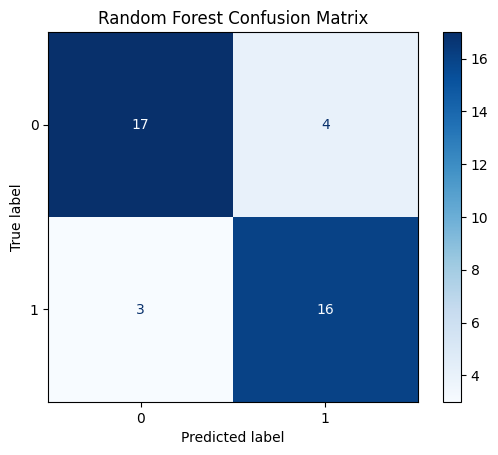

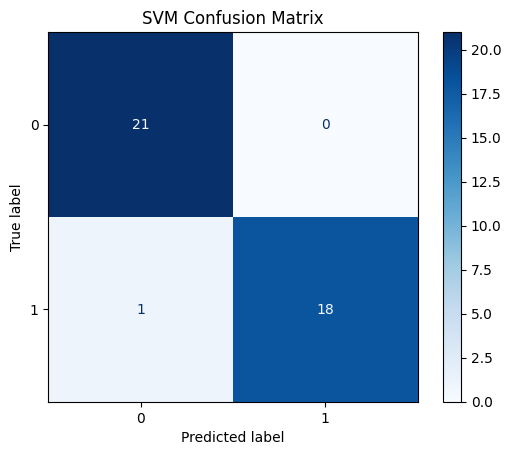

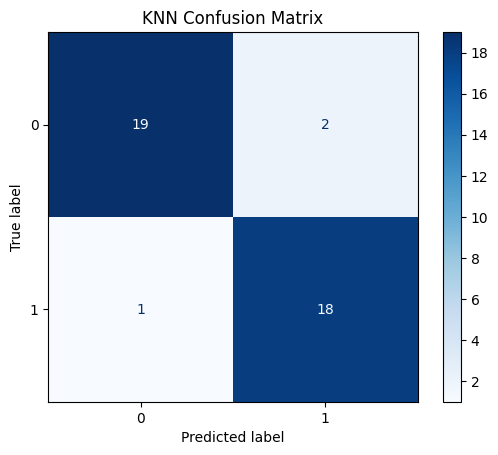

In [61]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

### Hasil Evaluasi & Analisis
Berdasarkan hasil evaluasi ketiga model, dapat disimpulkan bahwa model Support Vector Machine (SVM) dengan kernel RBF memberikan performa terbaik secara keseluruhan. Pada data testing, SVM mencapai akurasi 97.5% dengan precision dan recall yang sangat tinggi di kedua kelas, serta error yang sangat minim yaitu hanya 1 kesalahan klasifikasi. Model K-Nearest Neighbors (KNN) juga menunjukkan performa yang baik dengan akurasi 92.5% pada data testing, namun masih menghasilkan sedikit lebih banyak kesalahan dibanding SVM, khususnya di kelas 0 terdapat 2 kesalahan dan kelas 1 terdapat 1 kesalahan. Sedangkan model Random Forest memiliki performa paling rendah di antara ketiganya, dengan akurasi 82.5% pada data testing, dan kesalahan klasifikasi yang lebih besar baik di kelas 0 maupun 1. Performa Random Forest yang tinggi pada data training 99.3% namun lebih rendah pada testing mengindikasikan adanya sedikit overfitting, di mana model sangat baik mengenali data latih, namun kurang optimal pada data baru. Sementara itu, SVM menunjukkan keseimbangan yang sangat baik antara akurasi training 95.6% dan testing 97.5%, menandakan generalisasi model yang stabil. Dengan demikian, secara keseluruhan SVM paling cocok digunakan untuk klasifikasi tekstur citra pada dataset ini.